## QTLs called from principal components of gene clusters identify new variant associations


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import networkx as nx
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse, Circle




import ast
from tqdm.auto import tqdm 
tqdm.pandas()
import statsmodels.api as sm
from scipy.stats import ttest_ind


# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

In [2]:
# colors
gtex_tissue_dict = {
    "Adipose_Subcutaneous": "#FFA54F",
    "Adipose_Visceral_Omentum": "#EE9A00",
    "Artery_Tibial": "#FF0000",
    "Cells_Cultured_fibroblasts": "#9AC0CD",
    "Esophagus_Mucosa": "#8B7355",
    "Esophagus_Muscularis": "#CDAA7D",
    "Lung": "#9ACD32",
    "Muscle_Skeletal": "#7A67EE",
    "Nerve_Tibial": "#FFD700",
    "Skin_Not_Sun_Exposed_Suprapubic": "#3A5FCD",
    "Skin_Sun_Exposed_Lower_leg": "#1E90FF",
    "Thyroid": "#008B45",
    "Whole_Blood": "#FF00FF"
}

gtex_tissue_abbrev = ['ADPSBQ',
                      'ADPVSC',
                      'ARTTBL',
                      'FIBRBLS',
                      'ESPMCS',
                      'ESPMSL',
                      'LUNG',
                      'MSCLSK',
                      'NERVET',
                      'SKINNS',
                      'SKINS',
                      'THYROID',
                      'WHLBLD']

gtex_tissue_pal = sns.color_palette(list(gtex_tissue_dict.values()))
gtex_tissue_pal_df = pd.DataFrame(pd.Series(gtex_tissue_dict), columns=['hex']).reset_index(names=['tissue_id'])
gtex_tissue_pal

[(1.0, 0.6470588235294118, 0.30980392156862746),
 (0.9333333333333333, 0.6039215686274509, 0.0),
 (1.0, 0.0, 0.0),
 (0.6039215686274509, 0.7529411764705882, 0.803921568627451),
 (0.5450980392156862, 0.45098039215686275, 0.3333333333333333),
 (0.803921568627451, 0.6666666666666666, 0.49019607843137253),
 (0.6039215686274509, 0.803921568627451, 0.19607843137254902),
 (0.47843137254901963, 0.403921568627451, 0.9333333333333333),
 (1.0, 0.8431372549019608, 0.0),
 (0.22745098039215686, 0.37254901960784315, 0.803921568627451),
 (0.11764705882352941, 0.5647058823529412, 1.0),
 (0.0, 0.5450980392156862, 0.27058823529411763),
 (1.0, 0.0, 1.0)]

### a) Upset plot showing number coloc of pcQTLs and eQTLs 


In [3]:
# takes ~ 1:45
underlying_signals = load_across_tissues(config, load_signal_groups)
underlying_signals = remove_cross_map(underlying_signals, config=config)

In [4]:
underlying_signals['upset_color_label'] = np.where(underlying_signals['num_e_coloc'] > 0, np.where(underlying_signals['num_pc_coloc'] > 0, 'shared', 'eqtl_only'), 'pcqtl_only')
underlying_signals['upset_color_label_multiple'] = underlying_signals['upset_color_label']
underlying_signals.loc[((underlying_signals['upset_color_label'] == 'shared') & (underlying_signals['num_e_coloc'] > 1)),'upset_color_label_multiple'] = 'multiple_e_and_pc'
underlying_signals.loc[((underlying_signals['upset_color_label'] == 'eqtl_only') & (underlying_signals['num_e_coloc'] > 1)),'upset_color_label_multiple'] = 'multiple_e'

underlying_signals['upset_color_label_multiple'] = pd.Categorical(underlying_signals['upset_color_label_multiple'] ,
                                                                ['multiple_e', 'eqtl_only', 'pcqtl_only', 'multiple_e_and_pc', 'shared'])
underlying_signals['exclusive_label'] = np.where((underlying_signals['num_e_coloc'] > 0), np.where((underlying_signals['num_pc_coloc'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

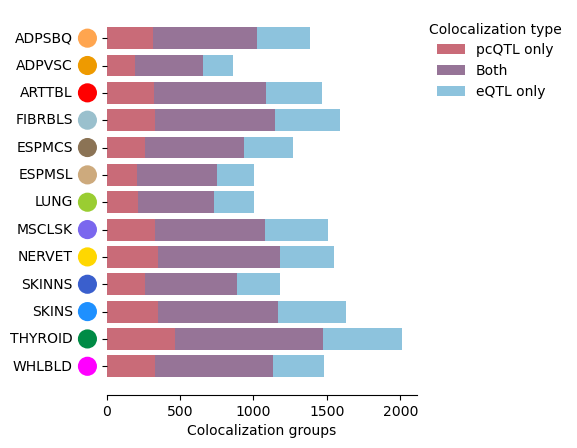

In [ ]:
fig, ax = plt.subplots(figsize=(4, 5))


sns.histplot(underlying_signals, y='tissue_id', hue='exclusive_label', multiple='stack',
            palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, 
            shrink=.8, edgecolor=None, ax=ax, hue_order=['eqtl_only', 'shared', 'pcqtl_only'])

# make the plot pretty
ax.spines[['top', 'left', 'right']].set_visible(False)
ax.set_xlabel('Colocalization groups')
ax.set_ylabel('')
ax.set_yticklabels('')

ax.legend(labels=['pcQTL only', 'Both', 'eQTL only'], title='Colocalization type', loc='upper left', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Add colored circles next to the y-ticks
for i, label in enumerate(gtex_tissue_abbrev):
    c = Ellipse((-130, i), 130, .7, clip_on=False, zorder=10, linewidth=0,
               edgecolor='none', facecolor=gtex_tissue_pal[i])
    ax.add_artist(c)
    ax.text(-230, i, label, verticalalignment='center', horizontalalignment='right')


dict_keys(['matrix', 'shading', 'totals', 'extra0'])


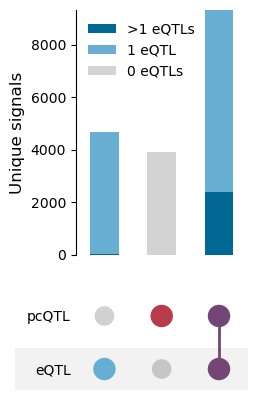

In [6]:
underlying_signals['multiple_e_color_label'] = np.where(underlying_signals['num_e_coloc'] > 1, '>1 eQTLs', np.where(underlying_signals['num_e_coloc'] > 0, '1 eQTL', '0 eQTLs'))
underlying_signals['eQTL'] = underlying_signals['num_e_coloc'] > 0
underlying_signals['pcQTL'] = underlying_signals['num_pc_coloc'] > 0
upset = underlying_signals.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(3,5))
upset = up.UpSet(upset, intersection_plot_elements=0, totals_plot_elements = 0, show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_color_label", title="Count", elements=4, colors=('lightgrey', '#67AFD2','#016895'))
upset.style_subsets(present=["eQTL"], absent=["pcQTL"], facecolor="#67AFD2", linewidth=2)
upset.style_subsets(present=["pcQTL"], absent=["eQTL"], facecolor="#B83A4B", linewidth=2)
upset.style_subsets(present=["eQTL", "pcQTL"], facecolor="#734675", linewidth=2)


# upset.style_categories(["eQTL"], bar_facecolor="#67AFD2", bar_edgecolor=None)
# upset.style_categories(["pcQTL"], bar_facecolor="#B83A4B", bar_edgecolor=None)


# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

# style the totals plot
totals_plot = plot_result["extra0"]
#totals_plot.set_xlim((8000, 0))
totals_plot.grid(False)
totals_plot.set_ylabel("Unique signals",  fontsize=12)

# upset.plot(fig=fig)
# plt.grid(False)

plt.legend(loc='upper left')
leg = plt.gca().get_legend()
leg.set_title('')
leg.set_frame_on(False)

plt.show()


### b) example of graph for coloc pairs

In [7]:
my_tissue_id='Thyroid'

pair_coloc = load_pairwise_coloc(config, my_tissue_id)
pair_coloc['cluster_id'] = pair_coloc['qtl1_id'].str.split('_e_').str[0].str.split('_pc').str[0]
pair_coloc['cluster_size'] = pair_coloc['cluster_id'].str.split('_').apply(len)

tissue_underlying_signals = load_signal_groups(config, my_tissue_id)
my_cluster_id = tissue_underlying_signals['cluster_id'].iloc[0]

def get_gene_name(gene_id):
    try:
        return gid_gencode.loc[gene_id]['gene_name']
    except KeyError:
        return gene_id
    
gid_gencode, full_gencode = load_gencode()

cluster_pairs = pair_coloc[pair_coloc['cluster_id'] == my_cluster_id]
cluster_pairs['qtl1_id_short'] = np.where(cluster_pairs['qtl1_id'].str.contains('_e_'), cluster_pairs['qtl1_id'].str.split('_e_').str[-1], 'PC' + cluster_pairs['qtl1_id'].str.split('_pc').str[-1])
cluster_pairs['qtl2_id_short'] = np.where(cluster_pairs['qtl2_id'].str.contains('_e_'), cluster_pairs['qtl2_id'].str.split('_e_').str[-1], 'PC' + cluster_pairs['qtl2_id'].str.split('_pc').str[-1])
cluster_pairs['qtl1_id_short'] = cluster_pairs['qtl1_id_short'].apply(get_gene_name) + '-cs' + cluster_pairs['idx1'].astype(str)
cluster_pairs['qtl2_id_short'] = cluster_pairs['qtl2_id_short'].apply(get_gene_name)+ '-cs' + cluster_pairs['idx2'].astype(str)

/local/scratch/klawren/slrmtmp.47796407/ipykernel_33988/2698803668.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_pairs['qtl1_id_short'] = np.where(cluster_pairs['qtl1_id'].str.contains('_e_'), cluster_pairs['qtl1_id'].str.split('_e_').str[-1], 'PC' + cluster_pairs['qtl1_id'].str.split('_pc').str[-1])
/local/scratch/klawren/slrmtmp.47796407/ipykernel_33988/2698803668.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_pairs['qtl2_id_short'] = np.where(cluster_pairs['qtl2_id'].str.cont

In [42]:
cluster_pairs['cluster_id'].iloc[0]

'ENSG00000117586.10_ENSG00000117592.8_ENSG00000162753.11_ENSG00000183831.6'

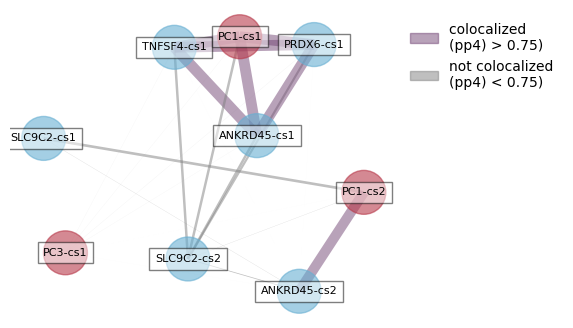

In [39]:
# Create an undirected graph
G = nx.Graph()

# Add edges to the graph with weights
for index, row in cluster_pairs.iterrows():
    G.add_edge(row['qtl1_id_short'], row['qtl2_id_short'], weight=row['PP.H4.abf'])

# Get edge weights for thickness
edge_weights = [G[u][v]['weight']*8 for u, v in G.edges()]

edge_colors = ['#734675' if G[u][v]['weight'] > 0.75 else 'gray' for u, v in G.edges()]
node_colors = ['#67AFD2' if not 'PC' in node else '#B83A4B' for node in G.nodes()]

fig, ax = plt.subplots(figsize=(5, 4)) 

pos = nx.spring_layout(G, k=1.5)  
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=node_colors, alpha=0.6, ax=ax)
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors, alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, bbox= dict(facecolor='white', alpha=0.5, edgecolor='k'))
ax.axis('off')  # Turn off the axis

# Create legend
purple_patch = mpatches.Patch(color='#734675', alpha=0.5, label='colocalized \n(pp4) > 0.75)')
gray_patch = mpatches.Patch(color='gray', alpha=0.5, label='not colocalized \n(pp4) < 0.75)')
ax.legend(handles=[purple_patch, gray_patch], loc='upper right', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

### c) egene pph4 for pc credible sets

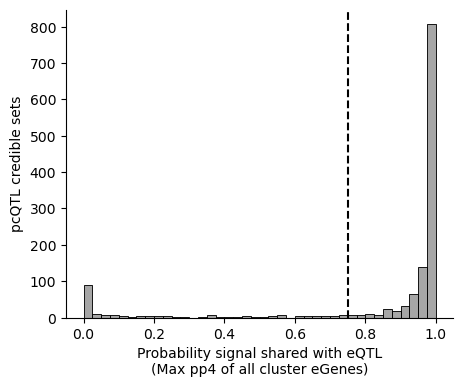

In [34]:
fig, ax = plt.subplots(figsize=(5,4))

# pair_coloc[(pair_coloc['qtl1_id'].str.contains('_pc'))&(pair_coloc['qtl2_id'].str.contains('_e_'))].groupby('qtl1_id').agg({'PP.H4.abf':max})
pc_coloc_with_any_e = pair_coloc[(pair_coloc['qtl1_id'].str.contains('_e_'))&(pair_coloc['qtl2_id'].str.contains('_pc'))].groupby('qtl2_id').agg({'PP.H4.abf':max}).reset_index()
pc_coloc_with_any_e['phenotype_id'] = pc_coloc_with_any_e['qtl2_id']
annotate_pc_order(pc_coloc_with_any_e)
pc_coloc_with_any_e['cluster_size_clip'] = pc_coloc_with_any_e['cluster_size'].clip(0,5)

sns.histplot(pc_coloc_with_any_e, x='PP.H4.abf', multiple='dodge', bins=40, ax=ax,
             common_norm=False, color='grey', alpha=.7)
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('pcQTL credible sets')
ax.set_xlabel('Probability signal shared with eQTL\n(Max pp4 of all cluster eGenes)')

ax.axvline(.75, color='k', ls='--')


plt.show()

### d) pcQTLs vs eQTL Signal to noise (1/CV)

In [ ]:
susie_annotated = load_across_tissues(config, load_susie_annotated)
susie_annotated = remove_cross_map(susie_annotated, config=config)

In [ ]:
# some did not annotate properly, not sure why? just remove for now
print(len(susie_annotated))
susie_annotated = susie_annotated[~(susie_annotated['egene_id_list'] == '[nan]')]
print(len(susie_annotated))
# to calculate cv, we need eqtl slope and eqtl slope se
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].progress_apply(ast.literal_eval)
susie_annotated['egene_qtl_slope_se'] = susie_annotated['egene_qtl_slope_se'].progress_apply(ast.literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].progress_apply(ast.literal_eval)

609650
602435


  0%|          | 0/602435 [00:00<?, ?it/s]

  0%|          | 0/602435 [00:00<?, ?it/s]

  0%|          | 0/602435 [00:00<?, ?it/s]

In [ ]:
# calculate the cv for each egene in the cluster
susie_egene_explode = susie_annotated.explode(['egene_qtl_slope', 'egene_qtl_slope_se', 'egene_id_list'])
# we take cv = sd/mean
# # becuase we are interested in the magnitude, not direction of effect, take the abs of the mean
susie_egene_explode['pip_egene_cv'] = (susie_egene_explode['egene_qtl_slope_se']/susie_egene_explode['egene_qtl_slope'].abs()) * susie_egene_explode['pip']
susie_egene_explode['pip_egene_var'] = susie_egene_explode['egene_qtl_slope']**2 * susie_egene_explode['pip']

# group by egene
egene_grouped = susie_egene_explode.groupby(['phenotype_id', 'tissue_id', 'cs_id', 'egene_id_list', 'cluster_id']).agg({'pip_egene_cv':'sum', 'pip_egene_var':'sum', 'type':'first'})
# group into credible sets, take the smallest CV (lowest error)
cs_grouped = egene_grouped.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg({'pip_egene_cv':'min', 'pip_egene_var':'max', 'type':'first'}).reset_index()
# merge into coloc signal groups
underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')
underlying_signals_explode = pd.merge(underlying_signals.explode('cs_id'), cs_grouped[['cs_id', 'tissue_id', 'pip_egene_cv', 'pip_egene_var']], on=['cs_id', 'tissue_id'], how='left')
underlying_signals_annotated = underlying_signals_explode.groupby(['signal_id', 'tissue_id']).agg({'pip_egene_cv':'min', 'pip_egene_var':'max', 'num_e_coloc':'first', 'num_pc_coloc':'first', 'exclusive_label':'first'})

In [ ]:
underlying_signals_annotated['pip_snr'] = 1/underlying_signals_annotated['pip_egene_cv']

/local/scratch/klawren/slrmtmp.47736715/ipykernel_56351/2417280495.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['both','eQTL only', 'pcQTL only'])


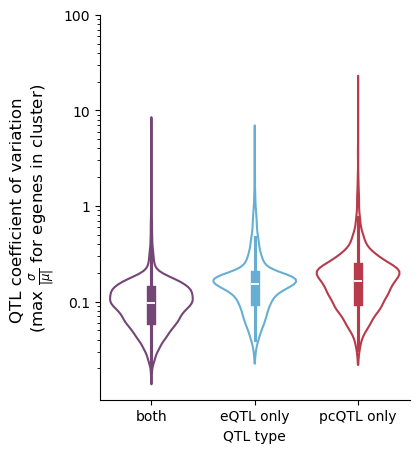

In [ ]:
fig, ax = plt.subplots(figsize=(4,5))

sns.violinplot(underlying_signals_annotated, y='pip_snr', x='exclusive_label', hue='exclusive_label', ax=ax, log_scale=True, palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, order=[ 'shared', 'eqtl_only', 'pcqtl_only'], legend=False, cut=0, fill=False)
ax.set_ylabel("QTL signal to noise ratio \n" r'(max $\frac{|\mu|}{\sigma}$ for egenes in cluster)', fontsize=12)
ax.set_xlabel('QTL type')
ax.set_xticklabels(['both','eQTL only', 'pcQTL only'])
#ax.set_yticks([.1, 1, 10, 100], labels=[.1, 1, 10, 100])
ax.spines[['top', 'right']].set_visible(False)

In [ ]:
underlying_signals_annotated_no_na = underlying_signals_annotated[~underlying_signals_annotated['pip_egene_cv'].isna()]
print('pc vs e')
print(ttest_ind(underlying_signals_annotated_no_na[underlying_signals_annotated_no_na['exclusive_label']=='pcqtl_only']['pip_egene_cv'].astype(float).values, underlying_signals_annotated_no_na[underlying_signals_annotated_no_na['exclusive_label']=='eqtl_only']['pip_egene_cv'].astype(float).values))

print('pc vs both')
print(ttest_ind(underlying_signals_annotated_no_na[underlying_signals_annotated_no_na['exclusive_label']=='pcqtl_only']['pip_egene_cv'].astype(float).values, underlying_signals_annotated_no_na[underlying_signals_annotated_no_na['exclusive_label']=='shared']['pip_egene_cv'].astype(float).values))

print('e vs both')
print(ttest_ind(underlying_signals_annotated_no_na[underlying_signals_annotated_no_na['exclusive_label']=='eqtl_only']['pip_egene_cv'].astype(float).values, underlying_signals_annotated_no_na[underlying_signals_annotated_no_na['exclusive_label']=='shared']['pip_egene_cv'].astype(float).values))

pc vs e
Ttest_indResult(statistic=2.084214274004335, pvalue=0.03717098479016303)
pc vs both
Ttest_indResult(statistic=18.784472960914414, pvalue=1.0559749739669284e-77)
e vs both
Ttest_indResult(statistic=22.8793303867713, pvalue=9.530379807992562e-114)


### c) pcQTLs detect signals at smaller sample sizes

In [3]:
subsample_output_folder = f'{prefix}/config/subsampling_constant_pcs'

# load in the configs for each 
subsample_nums = [200, 250, 300, 350, 400, 450]

sub_configs = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_configs[num_samples] = config

main_config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(main_config_path, 'r') as f:
    final_output_config = yaml.safe_load(f)

my_tissue_id = 'Cells_Cultured_fibroblasts'
sample_sizes = pd.read_csv(final_output_config['gtex_meta'], sep='\t')
final_sample_size = sample_sizes[sample_sizes['tissue_id']==my_tissue_id]['sample_size'].values[0]

In [4]:
# get the cluster specific nominal threshold
def get_threshold(config, tissue_id):
    threshold_pc = pd.read_csv('{}/{}/{}/{}.v8.pcs.cis_qtl.txt.gz'.format(prefix, config['pcqtl_output_dir'], tissue_id, tissue_id), sep='\t')
    threshold_e = pd.read_csv('{}/{}/{}/{}.v8.cluster_genes.cis_qtl.txt.gz'.format(prefix, config['eqtl_output_dir'], tissue_id, tissue_id), sep='\t')

    # average over all egenes and pcs in cluster
    threshold_e['cluster_id'] = threshold_e['phenotype_id'].str.split('_e_').str[0]
    threshold_e = threshold_e.groupby('cluster_id').agg({'pval_nominal_threshold':'mean'})
    threshold_pc['cluster_id'] = threshold_pc['phenotype_id'].str.split('_pc').str[0]
    threshold_pc = threshold_pc.groupby('cluster_id').agg({'pval_nominal_threshold':'mean'})
    thresholds = pd.merge(threshold_e, threshold_pc, on='cluster_id')
    thresholds['pval_nominal_threshold'] = (thresholds['pval_nominal_threshold_x'] + thresholds['pval_nominal_threshold_y'])/2
    return thresholds['pval_nominal_threshold']

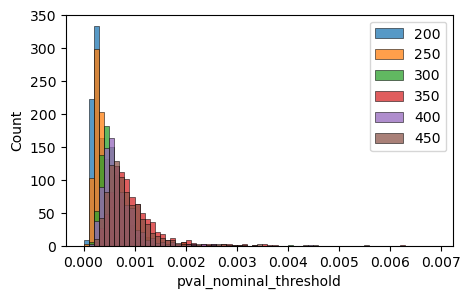

In [5]:
fig, ax = plt.subplots(figsize=(5,3))
median_nominal_threshold={}
median_nominal_threshold[final_sample_size] = np.median(get_threshold(final_output_config, my_tissue_id))
for subsample_size in subsample_nums:
    sub_threshold = get_threshold(sub_configs[subsample_size], my_tissue_id)
    median_nominal_threshold[subsample_size] = np.median(sub_threshold)
    sns.histplot(sub_threshold, label=subsample_size, ax=ax, bins=np.arange(0, .007, .0001))
plt.legend()
plt.show()

In [6]:
# takes 13 minutes for 1 tissues and 4 subsamples

# def get_pc_e_nominal(config, tissue_id, thresholds):
#     pc_nominal_df = load_pc_nominal_all_chr(config, tissue_id).groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
#     pc_nominal_df = pd.merge(pc_nominal_df.reset_index(), thresholds.reset_index(), on='cluster_id', how='left')
#     pc_nominal_df['sig'] = pc_nominal_df['pval_nominal'] < pc_nominal_df['pval_nominal_threshold']

#     e_nominal_df = load_e_nominal_all_chr(config, tissue_id).groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
#     e_nominal_df = pd.merge(e_nominal_df.reset_index(), thresholds.reset_index(), on='cluster_id', how='left')
#     e_nominal_df['sig'] = e_nominal_df['pval_nominal'] < e_nominal_df['pval_nominal_threshold']
    
#     combined_nominal = pd.merge(pc_nominal_df, e_nominal_df, suffixes=['_pc', '_e'], on=['cluster_id', 'variant_id']).reset_index()
#     combined_nominal['exclusive_label'] = np.where(combined_nominal['sig_e'],
#                                                np.where(combined_nominal['sig_pc'], 'shared', 'eqtl_only'), 
#                                                np.where(combined_nominal['sig_pc'], 'pcqtl_only', 'neither'))
#     return combined_nominal
# nominal_df = get_pc_e_nominal(final_output_config, my_tissue_id, get_threshold(sub_configs[200], my_tissue_id))
# for key in sub_configs:
#     print(key)
#     sub_nominal_df = final_nominal_df = get_pc_e_nominal(sub_configs[key], my_tissue_id, get_threshold(sub_configs[key], my_tissue_id))
#     nominal_df = pd.merge(nominal_df, sub_nominal_df, suffixes=['', f'_{key}'], on=['cluster_id', 'variant_id'])
# nominal_df.to_csv('/home/klawren/oak/pcqtls/output/subsampling_constant_pcs/merged_bycluster_nominal.txt.gz', sep='\t', compression='gzip', index=False)

# takes about 1 minute to load
nominal_df = pd.read_csv('/home/klawren/oak/pcqtls/output/subsampling_constant_pcs/merged_bycluster_nominal.txt.gz', sep='\t', compression='gzip')

In [54]:
# for variants signifignat as eqtls at full sample size, go backwards. what was the smallest sample size where they were signifignat as eqtls? as pcqtls?
eqtl_vars = nominal_df[nominal_df['exclusive_label_450'].isin(['shared'])]
eqtl_vars.groupby('sig_pc_450').size()

sig_pc_450
True    277245
dtype: int64

In [62]:
# Function to find the first true column
def first_true(row, qtl_type):
    for col in range(200, 451, 50):
        if row[f'sig_{qtl_type}_{col}']:
            return col
    return 500

# Apply the function to each row and create a new column
eqtl_vars['first_pc_sig'] = eqtl_vars.progress_apply(first_true, args=('pc',), axis=1)
eqtl_vars['first_e_sig'] = eqtl_vars.progress_apply(first_true, args=('e',), axis=1)


  0%|          | 0/277245 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.47767837/ipykernel_43839/2165087451.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eqtl_vars['first_pc_sig'] = eqtl_vars.progress_apply(first_true, args=('pc',), axis=1)


  0%|          | 0/277245 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.47767837/ipykernel_43839/2165087451.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eqtl_vars['first_e_sig'] = eqtl_vars.progress_apply(first_true, args=('e',), axis=1)


In [109]:
np.linspace(0, num_cutoffs, 4)

array([ 0.,  4.,  8., 12.])

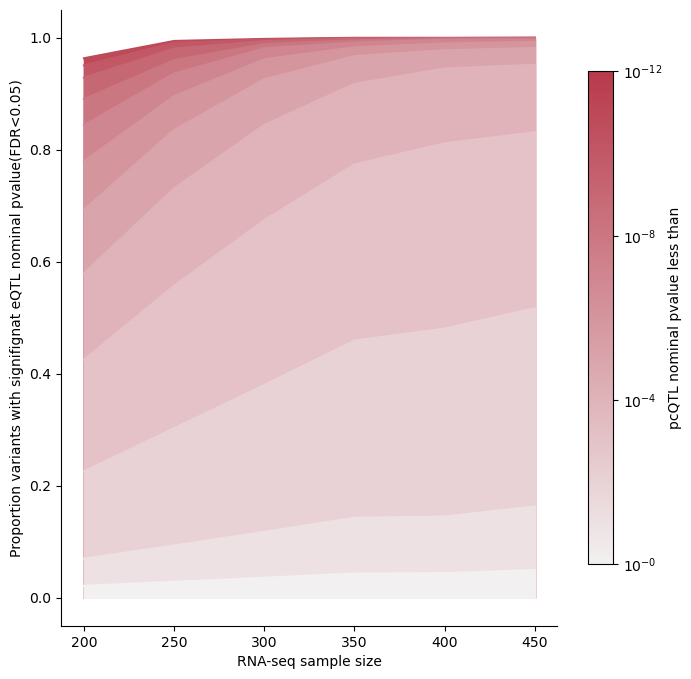

In [116]:
fig, ax = plt.subplots(figsize=(8,8))

num_cutoffs = 12
colors = sns.color_palette("light:#B83A4B", num_cutoffs + 1)  # Generate color palette
norm = plt.Normalize(0, num_cutoffs)
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("light:#B83A4B", num_cutoffs + 1, as_cmap=True), norm=norm)
#sm.set_array([])  # Only needed for older versions of Matplotlib


for i in range(num_cutoffs)[::-1]:
    pc_cutoff = 10**(-i)
    sub_pc_vars = nominal_df[nominal_df['pval_nominal_pc_400']<pc_cutoff]
    mean_values = sub_pc_vars[[f'sig_e_{col}' for col in range(200, 451, 50)]].mean(axis=0)
    ax.fill_between(range(200, 451, 50), mean_values, 
                    color=sns.color_palette("light:#B83A4B", num_cutoffs+1)[i])
    
    sns.lineplot(y=mean_values, x=range(200, 451, 50), 
                 color=sns.color_palette("light:#B83A4B", num_cutoffs+1)[i])

    # if i < 6:
    #     plt.text(450, mean_values.iloc[-1], f'{pc_cutoff:.1e}', 
    #             verticalalignment='center', horizontalalignment='left', 
    #             color='k')

ax.set_ylabel('Proportion variants with signifignat eQTL nominal pvalue(FDR<0.05)')
ax.set_xlabel('RNA-seq sample size')


cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=.8)
cbar.set_label('pcQTL nominal pvalue less than')
cbar.set_ticks(np.linspace(0, num_cutoffs, 4))  # Set ticks for the colorbar
cbar.set_ticklabels([r'$10^{-%.0f}$' % i for i in np.linspace(0, num_cutoffs, 4)])  # Set tick labels

ax.spines[['top', 'right']].set_visible(False)


In [ ]:
# make a subset df
var_num=1000
small = pd.concat([nominal_df[(nominal_df['exclusive_label_200']=='pcqtl_only')].sample(var_num), 
         nominal_df[(nominal_df['exclusive_label_200']=='eqtl_only')].sample(var_num), 
         nominal_df[(nominal_df['exclusive_label_200']=='shared')].sample(var_num),
         nominal_df[(nominal_df['exclusive_label_200']=='neither')].sample(var_num)])
col_names = [f'pval_nominal_e_{num}' for num in subsample_nums]
col_names.append(f'pval_nominal_e_{final_sample_size}')
small[f'pval_nominal_e_{final_sample_size}'] = small['pval_nominal_e']

/local/scratch/klawren/slrmtmp.47736715/ipykernel_56351/4251462720.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([10e-30, 0])
/local/scratch/klawren/slrmtmp.47736715/ipykernel_56351/4251462720.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([10e-30, 0])


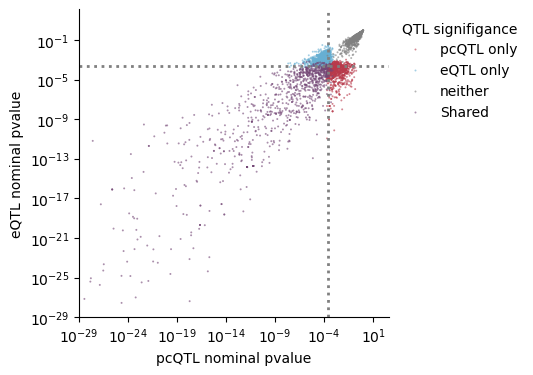

In [ ]:
# make a chart showing signifigance breakdown for all vars in 200 sample
fig, ax = plt.subplots(figsize=(4,4))

nominal_palette = ["#B83A4B", "#67AFD2", "grey", "#734675"]

sns.scatterplot(small, y='pval_nominal_pc_200', x='pval_nominal_e_200', hue='exclusive_label_200', ax=ax, ec='none', s=2, alpha=.6, palette=nominal_palette, hue_order=['pcqtl_only', 'eqtl_only', 'neither', 'shared'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10e-30, 0])
ax.set_ylim([10e-30, 0])

ax.axhline(median_nominal_threshold[200], color='grey', linestyle=':', linewidth=2)
ax.axvline(median_nominal_threshold[200], color='grey', linestyle=':', linewidth=2)

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('eQTL nominal pvalue')
ax.set_xlabel('pcQTL nominal pvalue')



# Change legend title
ax.legend( title='QTL signifigance', loc='upper left', frameon=False)
sns.move_legend(ax,  "upper left", labels=['pcQTL only', 'eQTL only', 'neither', 'Shared'], bbox_to_anchor=(1, 1))



In [ ]:
# clip the values
small[col_names] = small[col_names].clip(1, 1e-20)

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(8,8))
# # Loop through each row to plot lines
# for idx, row in small.iterrows():
#     if row['exclusive_label_200'] == 'neither':
#         axes[0,0].plot([*subsample_nums, final_sample_size], row[col_names], color='k', alpha=0.5, linewidth=0.1)
#     elif row['exclusive_label_200'] == 'eqtl_only':
#         axes[1,0].plot([*subsample_nums, final_sample_size], row[col_names], color='#67AFD2', alpha=0.5, linewidth=0.1)
#     elif row['exclusive_label_200'] == 'pcqtl_only':
#         axes[0,1].plot([*subsample_nums, final_sample_size], row[col_names], color='#B83A4B', alpha=0.5, linewidth=0.1)
#     else:
#         axes[1,1].plot([*subsample_nums, final_sample_size], row[col_names], color='#734675', alpha=0.5, linewidth=0.1)

# # all axes
# for ax in [ax for ax_row in axes for ax in ax_row]:
#     ax.set_yscale('log')
#     ax.set_ylim([1, 1e-20])
#     ax.set_yticks([1, 1e-10, 1e-20])
#     ax.set_xlabel('QTL type')
#     ax.spines[['top', 'right']].set_visible(False)
#     # ax.axhline(1e-5, color='grey', linestyle=':', linewidth=2)
#     ax.plot([*subsample_nums, final_sample_size], 
#             [median_nominal_threshold[s] for s in [*subsample_nums, final_sample_size]], color='grey', linestyle=':', linewidth=2)


# # bottom row
# for ax in [axes[1,0], axes[1,1]]:
#     ax.set_xlabel('Sample size')
#     ax.set_xticks([200, 300, 400, final_sample_size])

# # top row
# for ax in [axes[0,0], axes[0,1]]:
#     ax.set_xlabel('')
#     ax.set_xticks([200, 300, 400, final_sample_size])
#     ax.set_xticklabels(['']*4)

# # left column
# for ax in[axes[0,0], axes[1,0]]:
#     ax.set_ylabel('eQTL pvalue \n(min of cluster eGenes)')

# # right column
# for ax in[axes[1,1], axes[0,1]]:
#     ax.set_ylabel('')
#     ax.set_yticklabels(['']*3)

# axes[0,0].set_title('pcQTL not significant N=200')
# axes[0,1].set_title('pcQTL significant N=200')

# fig.tight_layout()
# # tight_layout doesn't take these labels into account. We'll need 
# # to make some room. These numbers are are manually tweaked. 
# # You could automatically calculate them, but it's a pain.
# fig.subplots_adjust(left=0.15, top=0.95)


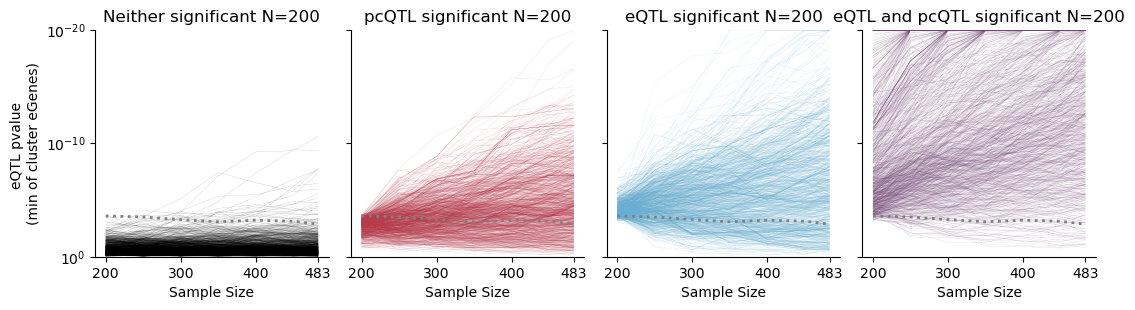

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))
# Loop through each row to plot lines
for idx, row in small.iterrows():
    if row['exclusive_label_200'] == 'neither':
        axes[0].plot([*subsample_nums, final_sample_size], row[col_names], color='k', alpha=0.5, linewidth=0.1)
    elif row['exclusive_label_200'] == 'eqtl_only':
        axes[2].plot([*subsample_nums, final_sample_size], row[col_names], color='#67AFD2', alpha=0.5, linewidth=0.1)
    elif row['exclusive_label_200'] == 'pcqtl_only':
        axes[1].plot([*subsample_nums, final_sample_size], row[col_names], color='#B83A4B', alpha=0.5, linewidth=0.1)
    else:
        axes[3].plot([*subsample_nums, final_sample_size], row[col_names], color='#734675', alpha=0.5, linewidth=0.1)

# all axes
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1, 1e-20])
    ax.set_yticks([1, 1e-10, 1e-20])
    ax.set_xlabel('Sample Size')
    ax.set_xticks([200, 300, 400, final_sample_size])
    ax.spines[['top', 'right']].set_visible(False)
    # ax.axhline(1e-5, color='grey', linestyle=':', linewidth=2)
    ax.plot([*subsample_nums, final_sample_size], 
            [median_nominal_threshold[s] for s in [*subsample_nums, final_sample_size]], color='grey', linestyle=':', linewidth=2)

for ax in axes[1:]:
     ax.set_yticklabels(['']*3)

axes[0].set_ylabel('eQTL pvalue \n(min of cluster eGenes)')
axes[0].set_title('Neither significant N=200')
axes[1].set_title('pcQTL significant N=200')
axes[2].set_title('eQTL significant N=200')
axes[3].set_title('eQTL and pcQTL significant N=200')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.95)


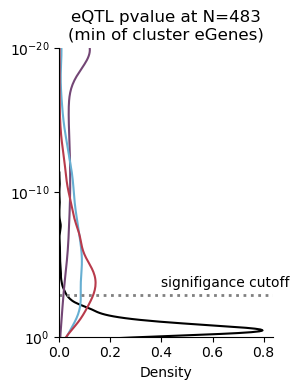

In [ ]:
fig, ax = plt.subplots(figsize=(3,4))

sns.kdeplot(small, y='pval_nominal_e_483', hue='exclusive_label_200', log_scale=True, common_norm=False, 
            palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675', 'neither':'k'}, legend=False)
ax.invert_yaxis()
ax.axhline(median_nominal_threshold[final_sample_size], color='grey', linestyle=':', linewidth=2)
ax.set_ylim([1, 1e-20])
ax.set_yticks([1, 1e-10, 1e-20])
ax.spines[['top', 'right']].set_visible(False)

ax.set_title('eQTL pvalue at N=483\n(min of cluster eGenes)')
ax.set_ylabel('')

ax.annotate('signifigance cutoff', xy=(.4, median_nominal_threshold[final_sample_size]-.001))

# Change legend title
#ax.legend( title='QTL signifigance', loc='upper left', frameon=False)
#sns.move_legend(ax,  "upper left", labels=['pcQTL only', 'eQTL only', 'both', 'neither'], bbox_to_anchor=(1, 1), frameon=False, title='QTL signifigance at N=200')
fig.tight_layout()
plt.show()

(0.0, 1.0)

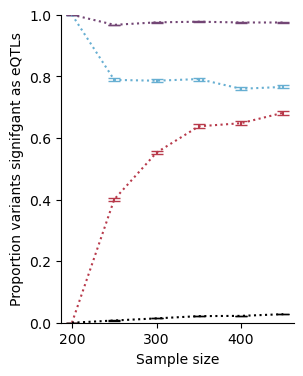

In [ ]:
fig, ax = plt.subplots(figsize=(3,4))

for qtl_type, c in zip(['pcqtl_only', 'eqtl_only', 'shared', 'neither'], ['#B83A4B','#67AFD2', '#734675', 'k']):
    sub_200 = nominal_df[nominal_df['exclusive_label_200'] == qtl_type]
    fraction_eqtl = []
    se_eqtl = []
    for s in subsample_nums:
        p = sub_200[f'exclusive_label_{s}'].isin(['eqtl_only', 'shared']).sum()/len(sub_200)
        fraction_eqtl.append(p)
        se_eqtl.append(np.sqrt((p*(1-p))/len(sub_200)) * 1.96)

    ax.errorbar(x=subsample_nums, y=fraction_eqtl, yerr=se_eqtl, fmt=':', c=c, capsize=4)

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('Proportion variants signifgant as eQTLs')
ax.set_xlabel('Sample size')
ax.set_ylim([0,1])

### d) forest plot for pcqtl vs eqtl enrichments


In [ ]:
clusters = load_across_tissues(final_output_config, load_clusters_annotated)

# add cluster annotation to signals
underlying_signals_clusters = pd.merge(underlying_signals, clusters, on='cluster_id', how='left', suffixes=['', '_cluster'])

In [ ]:
# break out by gene id so I can match vep effects to genes in the cluster
susie_annotated['gene_id'] = susie_annotated['cluster_id'].str.split('_')
susie_annotated_explode = susie_annotated.explode('gene_id')

def get_gene_matched_effect(row):
    gene_matched_effect = []
    for vep_effect in row['vep_info'].split(','):
        if row['gene_id'].split('.')[0] in vep_effect:
            gene_matched_effect.append(vep_effect.split('|')[1])
    return list(set(gene_matched_effect))

susie_annotated_explode['vep_info_gene'] = susie_annotated_explode.progress_apply(get_gene_matched_effect, axis=1).astype(str)

# check for effects specific to a gene, with some groupings
#susie_annotated_explode['vep_gene_matched_nmd'] = susie_annotated_explode['vep_info_gene'].str.contains('stop_gained|frameshift_variant', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_nmd'] = susie_annotated_explode['vep_info_gene'].str.contains('stop_gained', regex=True).astype(float) * susie_annotated_explode['pip']

susie_annotated_explode['vep_gene_matched_exon'] = susie_annotated_explode['vep_info_gene'].str.contains('stop_retained_variant|missense_variant|synonymous_variant|exon_variant|stop_lost|protein_altering_variant|inframe_deletion|coding_sequence_variant|start_lost|inframe_insertion', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_intron'] = susie_annotated_explode['vep_info_gene'].str.contains('UTR_variant|intron_variant', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_splice'] = susie_annotated_explode['vep_info_gene'].str.contains('splice', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_neargene'] = susie_annotated_explode['vep_info_gene'].str.contains('downstream_gene_variant|upstream_gene_variant', regex=True).astype(float) * susie_annotated_explode['pip']

# any effect on the transcript
susie_annotated_explode['vep_any_effect'] = (susie_annotated_explode['vep_info_gene'].str.strip("'[],").apply(len) > 0).astype(float) * susie_annotated_explode['pip']

# vep related but not gene specific
susie_annotated_explode['vep_open_chrom'] = susie_annotated_explode['vep_info'].str.contains('open_chromatin_region').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_reg'] = susie_annotated_explode['vep_info'].str.contains('regulatory_region_variant').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_enhancer'] = susie_annotated_explode['vep_info'].str.contains('enhancer').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_promoter'] = susie_annotated_explode['vep_info'].str.contains('promoter').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_CTCF'] = susie_annotated_explode['vep_info'].str.contains('CTCF_binding_site').astype(float) * susie_annotated_explode['pip']

# some annotaitons for the abc enhancers 
susie_annotated_explode['in_shared_abc'] = (susie_annotated_explode['qtl_matched_abc_genes'] > 1) * susie_annotated_explode['pip']
susie_annotated_explode['in_matched_abc'] = (susie_annotated_explode['qtl_matched_abc_genes'] > 0) * susie_annotated_explode['pip']
susie_annotated_explode['in_abc'] = (susie_annotated_explode['qtl_num_abc_enhancers'] > 0) * susie_annotated_explode['pip']
susie_annotated_explode['qtl_in_tad'] = (susie_annotated_explode['qtl_in_tad']) * susie_annotated_explode['pip']

# group by egene
egene_grouped = susie_annotated_explode.groupby(['phenotype_id', 'tissue_id', 'cs_id', 'gene_id', 'cluster_id']).agg({'vep_gene_matched_nmd':'sum', 
                                                                                                                        'vep_gene_matched_exon':'sum', 
                                                                                                                        'vep_gene_matched_intron':'sum',
                                                                                                                        'vep_gene_matched_splice':'sum',
                                                                                                                        'vep_any_effect':'sum',
                                                                                                                        'vep_open_chrom':'sum',
                                                                                                                        'vep_enhancer':'sum',
                                                                                                                        'vep_promoter':'sum',
                                                                                                                        'vep_CTCF':'sum',
                                                                                                                        'in_shared_abc':'sum',
                                                                                                                        'in_matched_abc':'sum',
                                                                                                                        'in_abc':'sum',
                                                                                                                        'qtl_in_tad':'sum',
                                                                                                                        'pip':'sum',
                                                                                                                        'type':'first'})

                                                                                                                        # group into credible sets over egenes. take the max and the count of those greater than 0 for each category
cs_grouped = egene_grouped.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg(max_vep_nmd=('vep_gene_matched_nmd','max'),
                                                                                             count_vep_nmd=('vep_gene_matched_nmd',lambda x: (x > 0).sum()),
                                                                                             max_vep_exon=('vep_gene_matched_exon','max'),
                                                                                             count_vep_exon=('vep_gene_matched_exon',lambda x: (x > 0).sum()),
                                                                                             max_vep_intron=('vep_gene_matched_intron','max'),
                                                                                             count_vep_intron=('vep_gene_matched_intron',lambda x: (x > 0).sum()),
                                                                                             max_vep_splice=('vep_gene_matched_splice','max'),
                                                                                             count_vep_splice=('vep_gene_matched_splice',lambda x: (x > 0).sum()),
                                                                                             max_vep_any=('vep_any_effect','max'),
                                                                                             count_vep_any=('vep_any_effect',lambda x: (x > 0).sum()),
                                                                                             vep_open_chrom=('vep_open_chrom','max'),
                                                                                             vep_enhancer=('vep_enhancer','max'),
                                                                                             vep_promoter=('vep_promoter','max'),
                                                                                             vep_CTCF=('vep_CTCF','max'),
                                                                                             in_shared_abc=('in_shared_abc','max'),
                                                                                             in_matched_abc=('in_matched_abc','max'),
                                                                                             in_abc=('in_abc','max'),
                                                                                             qtl_in_tad=('qtl_in_tad','max'),
                                                                                             type=('type', 'first'))

                                                                                             # merge in signal group informaiton
underlying_signals_clusters['cs_id'] = underlying_signals_clusters['signal_id'].str.split('-')
cs_grouped_signal_annotated = pd.merge(underlying_signals_clusters.explode('cs_id'), cs_grouped, on=['cs_id', 'tissue_id'], how='left')
cs_grouped_signal_annotated = cs_grouped_signal_annotated[~(cs_grouped_signal_annotated['max_vep_any'].isna())]

# group over signals and take the mean of each column
signal_grouped = cs_grouped_signal_annotated.groupby(['signal_id', 'tissue_id', 'cluster_id']).agg(dict([(col, 'mean') for col in cs_grouped.columns[:-1]]))
signal_grouped = pd.merge(underlying_signals_clusters, signal_grouped, on=['signal_id', 'tissue_id'], how='left')
signal_grouped['cluster_size'] = signal_grouped['cluster_id'].str.split('_').apply(len)
signal_grouped = signal_grouped[~signal_grouped['max_vep_nmd'].isna()]
signal_grouped['vep_single_gene'] = (signal_grouped['count_vep_any'] <= 1) & (signal_grouped['max_vep_any']!=0)
signal_grouped['vep_multi_gene'] = signal_grouped['count_vep_any'] > 1

In [ ]:
underlying_signals_dupped = pd.concat([signal_grouped[signal_grouped['num_pc_coloc']>0], signal_grouped[signal_grouped['num_e_coloc']>0]], keys=[True, False], names=['is_pcqtl', 'signal_id', 'tissue_id'])
underlying_signals_dupped = underlying_signals_dupped[~underlying_signals_dupped['pip_qtl_in_tad'].isna()]

final_plot_columns = ['has_high_pos_corr', 'pip_qtl_in_tad', 'pip_vep_all_genes', 'pip_vep_promoter', 'pip_vep_enhancer', 'pip_vep_CTCF', 'pip_vep_open_chrom', 'pip_vep_nmd', 'pip_vep_intron', 'pip_vep_exon']

or_pce = get_odds_df(underlying_signals_dupped, label_col='is_pcqtl', column_list=final_plot_columns[::-1], correct_on=True, correct_on_column='cluster_size')
or_pce.reset_index(inplace=True)

pip_vep_exon
Optimization terminated successfully.
         Current function value: 0.692791
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                26949
Model:                          Logit   Df Residuals:                    26946
Method:                           MLE   Df Model:                            2
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:               8.482e-07
Time:                        16:37:34   Log-Likelihood:                -18670.
converged:                       True   LL-Null:                       -18670.
Covariance Type:            nonrobust   LLR p-value:                    0.9843
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0540      0.015     -3.517      0.000      -0.084      -0.024
cluster_si

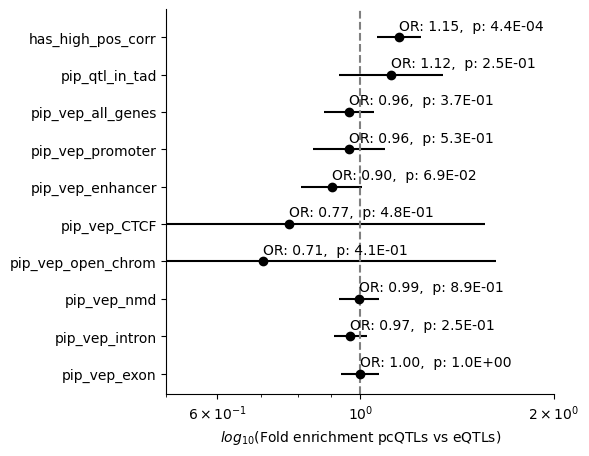

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(y=or_pce['col'], x=or_pce['odds_ratio'], xerr=np.clip(or_pce[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), -3, 3), fmt="o", color='k')
# add line at 0
ax.axvline(1, color='grey', linestyle='--')
# add annotations
for idx, row in or_pce.iterrows():
    ax.annotate('OR: {:.2f},  p: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2), fontsize=10)

# give some more space on the y axis
ax.set_ylim((ax.get_ylim()[0]-.1, ax.get_ylim()[1]+.3))
#ax.set_yticklabels(['High cluster correlation', 'TAD boundry', 'VEP effect on gene', 'Promoter', 'Enhancer', 'CTCF site', 'Open chromatin'][::-1])

# format the x axis
ax.set_xlabel(r'$log_{10}$(Fold enrichment pcQTLs vs eQTLs)')
ax.set_xscale('log')
ax.set_xlim([.5, 2])
ax.set_xticks([.6, 1, 2])


ax.spines[['top', 'right']].set_visible(False)


## Supplementary

Text(45.722222222222214, 0.5, 'Number PCs colocalized')

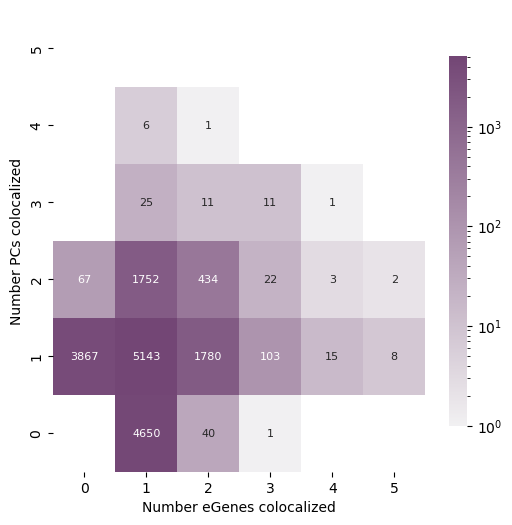

In [ ]:
hist, xedges, yedges = np.histogram2d(
    underlying_signals['num_pc_coloc'], 
    underlying_signals['num_e_coloc'], 
    bins=np.arange(7)
)

fig, ax = plt.subplots(figsize=(6, 6)) 

sns.heatmap(hist, ax=ax, cbar_kws={'shrink':.8}, norm=LogNorm(), cmap=sns.light_palette('#734675', as_cmap=True), annot=True, fmt='.0f', annot_kws={'size': 8})
ax.invert_yaxis()
ax.set_xlabel('Number eGenes colocalized')
ax.set_ylabel('Number PCs colocalized')